# Coupled ODE Integration

This notebook demonstrates integration of coupled ODEs and numerical integration of arrays of values in Python using a physically motivated example.

## A Ballistic Trajectory with Drag

The force on an object (a golfball or cannonball) moving in a uniform gravitation field with air resistance is given by

$$
\vec{F} = -mg\hat{z}-\frac{1}{2}\rho C_d Av^2 \hat{v},
$$

where gravity acts in the $\hat{z}$ direction, $\rho$ is the density of air, $C_d$ is the drag coefficient of the object in air, and $A$ is its cross-sectional area. $C_d$ depends heavily on whether or not the air flow in the wake of the object is laminar or turbulent, and thus depends on both the speed and shape of the object.

Writing this expression in terms of the object's position vector $\vec{r}$ we have

$$
\begin{align}
m\ddot{\vec{r}} &= -mg\hat{z} -\frac{1}{2}\rho C_d A|\dot{\vec{r}}|^2 \frac{\dot{\vec{r}}}{|\dot{\vec{r}}|} \\
 \frac{d}{dt}\dot{\vec{r}} &= -g\hat{z} - \alpha|\dot{\vec{r}}|\dot{\vec{r}},
\end{align}
$$

where $\alpha=1/(2m)~\rho C_d A$. Without loss of generality, restrict the motion to the $xz$ plane. Then the expression above can be written as two coupled first-order ODEs in velocity:

$$
\begin{align}
 \frac{d}{dt}\dot{x} &= -\alpha\dot{x}\sqrt{\dot{x}^2 + \dot{z}^2},
 &
 \frac{d}{dt}\dot{z} &= -mg -\alpha\dot{z}\sqrt{\dot{x}^2 + \dot{z}^2}.
\end{align}
$$

## Numerical Solution

In this example, we use the `odeint` function from `scipy.integrate` to solve for the components of the velocity $\dot{x}$ and $\dot{z}$. Then we can use the trapezoidal rule to estimate the trajectory $x(t)$ and $z(t)$.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import odeint, cumtrapz

mpl.rc('font', size=14)

In [2]:
g = 9.8

def ballistic(V, t, m, A, rho, Cd):
    """Velocity equations for ballistic motion with drag.
    Assume SI units for all inputs.
    
    Parameters
    ----------
    V : list
        Velocity in x and z.
    t : float
        Time point used to solve for v.
    m : float
        Object mass [kg].
    A : float
        Object area [m2].
    rho : float
        Air density [kg/m3].
    Cd : float
        Drag coefficient.
        
    Returns
    -------
    dVdt : list
        Velocity time derivative along x and z axes.
    """
    vx, vz = V
    alpha = rho*Cd*A/(2*m)
    vmag = np.sqrt(vx**2 + vz**2)
    dVdt = [   -alpha*vx*vmag,
            -g -alpha*vz*vmag]
    return dVdt

## Initial Conditions

Choose a $45^\circ$ initial trajectory and an initial velocity of 40 m/s or about 90 mph. Then integrate the motion for 6 seconds.

The object properties and drag coefficients are roughly those of a baseball.

In [3]:
v0 = 40.
angle = 45*np.pi/180.
V0 = [v0*np.cos(angle), v0*np.sin(angle)]

t = np.linspace(0, 6., 1001)

# Object properties and drag coefficients.
m = 0.15 # kg
rho = 1.225 # kg/m3
Cd = 0.5
r = 0.0366
A = np.pi * r**2 # m2

## Solve for the Motion

Consider several cases:
1. No drag (vacuum).
2. Drag, using sea-level air density.
3. Drag, using air density at 1.4 km.
4. Drag, using air density at 4 km.

In [4]:
# Solve for vx, vz with no drag.
# Then numerically integrate vx, vz to get x(t) and z(t).
v = odeint(ballistic, V0, t, args=(m, A, rho, 0.)).T
x_vac, z_vac = [cumtrapz(v[i], t) for i in range(2)]

# Solve with drag.
# Numerically integrate vx, vz to get x(t) and z(t).
v = odeint(ballistic, V0, t, args=(m, A, rho, Cd)).T
x_air, z_air = [cumtrapz(v[i], t) for i in range(2)]

# Solve with drag, using high-altitude air density (~1.4 km up).
# Numerically integrate vx, vz to get x(t) and z(t).
v = odeint(ballistic, V0, t, args=(m, A, 1.069, Cd)).T
x_alt, z_alt = [cumtrapz(v[i], t) for i in range(2)]

# Solve with drag, using very high-altitude air density (~4 km).
# Numerically integrate vx, vz to get x(t) and z(t).
v = odeint(ballistic, V0, t, args=(m, A, 0.81, Cd)).T
x_ha, z_ha = [cumtrapz(v[i], t) for i in range(2)]

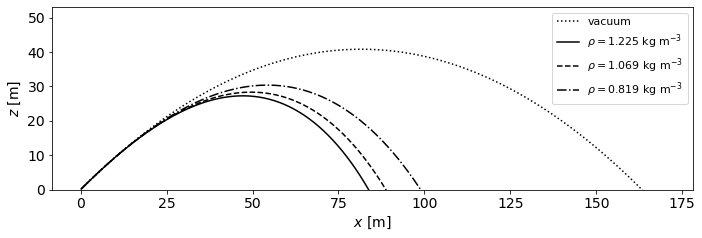

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,4), tight_layout=True)
ax.plot(x_vac, z_vac, 'k:', label='vacuum')
ax.plot(x_air, z_air, 'k', label=r'$\rho=1.225$ kg m$^{-3}$')
ax.plot(x_alt, z_alt, 'k--', label=r'$\rho=1.069$ kg m$^{-3}$')
ax.plot(x_ha,  z_ha,  'k-.', label=r'$\rho=0.819$ kg m$^{-3}$')

ax.set(aspect='equal',
       xlabel='$x$ [m]',
       ylim=(0,1.3*np.max(z_vac)),
       ylabel='$z$ [m]')

leg = ax.legend(fontsize=11)